# Visualizations 

In [11]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from Bio import AlignIO
from anarci import anarci
from collections import Counter
from math import log2

In [12]:
work_dir = os.getcwd()
data_dir = os.path.join(work_dir, '../data')
data = pd.read_csv(os.path.join(data_dir, 'raw/dataset_w_partition.csv'))
display(data)

,Unnamed: 0,Antibody Name,Epitope Group,source,D614G,BA.1,BA.2,BA.2.75,BA.5,BQ.1.1,...,Heavy chain V gene,Heavy chain J gene,Light chain V gene,Light chain J gene,Heavy chain AA,Light chain AA,clus_vh,clus_vl,connected,partition
0,0,BD-196,C,WT convalescents,1.93,>10,>10,>10,>10,>10,...,IGHV1-3,IGHJ6,IGKV2-58,IGKJ1,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYAMHWVRQAPGQRLE...,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPG...,1442,682,0,Validation
1,1,BD-218,A,WT convalescents,0.0104,0.00849,0.00937,0.0116,5.26,>10,...,IGHV4-34,IGHJ1,IGKV3-11,IGKJ5,QVQLQQWGAGLLKPSETLSLTCAVYGGSFSDYFWYWIRQPPGKGLE...,EIVLTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...,1443,508,1,Train
2,2,BD-236,A,WT convalescents,0.0173,>10,>10,>10,>10,>10,...,IGHV3-53,IGHJ6,IGKV1-9,IGKJ4,EVQLVESGGGLIQPGGSLRLSCAASGITVSSNYMSWVRQAPGKGLE...,IQLTQSPSSLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKLL...,595,591,1,Test
3,3,BD-254,C,WT convalescents,0.25,>10,>10,>10,>10,>10,...,IGHV3-23,IGHJ4,IGLV7-46,IGLJ2,EVQLLESGGGLVQPGGSLRLSCAASGFTLSSYAMSWVRQAPGRGLE...,QAVVTQEPSLTVSPGGTVTLTCGSSTGAVTSGHYPYWFQQKPGQAP...,1444,683,2,Validation
4,4,BD-255,B,WT convalescents,0.113,>10,>10,>10,>10,>10,...,IGHV3-30,IGHJ6,IGKV3-15,IGKJ2,QVQLVESGGGVVQPGRSLRLSCVASGFTFSNYDMHWVRQAPGKGLE...,EIVMTQSPAILSVSPGERATLSCRASQSVTRNLAWYQQKPGQAPRL...,1450,684,3,Validation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,3046,BD55-6726,E2.2,SARS convalescents,>10,>10,>10,>10,>10,>10,...,IGHV1-58,IGHJ2,IGKV3-24,IGKJ1,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...,EIVLRQSPATVSLSPGERATLSCRASQSVHNYLAWFQQKPGQAPRL...,2157,913,807,Validation
3047,3047,BD55-6727,F2,SARS convalescents,0.293,4.37,>10,>10,>10,>10,...,IGHV3-11,IGHJ1,IGKV1-39,IGKJ2,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQSISNYLNWYQQKPGKAPKL...,2158,456,1,Train
3048,3048,BD55-6728,F1,SARS convalescents,>10,>10,>10,>10,>10,>10,...,IGHV3-64,IGHJ2,IGKV1-39,IGKJ1,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...,DIQMTQSPSSLSASLGDRVTITCRASQTISRYLNWYQQKPGKAPKV...,2159,456,1,Train
3049,3049,BD55-6729,F1,SARS convalescents,>10,>10,>10,>10,>10,>10,...,IGHV1-18,IGHJ6,IGLV3-25,IGLJ2,QVQLVQSGAEVKKPGTSMRVSCKASGYTFSTYGIIWVRQAPGQGLE...,SYELTQPPSVSVSPGQTARITCSGDAVATQFLYWYQQKSGQAPVMV...,2160,914,808,Validation


In [13]:
with open("seq_heavy.fasta", "w") as fasta_file:
    for _, row in data.iterrows():
        fasta_file.write(f">{row['Unnamed: 0']}\n") 
        fasta_file.write(f"{row['Heavy chain AA']}\n")   

with open("seq_light.fasta", "w") as fasta_file:
    for _, row in data.iterrows():
        fasta_file.write(f">{row['Unnamed: 0']}\n")  
        fasta_file.write(f"{row['Light chain AA']}\n")   

In [16]:
heavy_seqs = [(name + '_H', seq) for name, seq in data[['Antibody  Name', 'Heavy chain AA']].values]
light_seqs = [(name + '_L', seq) for name, seq in data[['Antibody  Name', 'Light chain AA']].values]

In [17]:
heavy_results = anarci(heavy_seqs, scheme="imgt", output=False)
light_results = anarci(light_seqs, scheme="imgt", output=False)

hc_numbering, hc_alignment_details, hc_hit_tables = heavy_results
lc_numbering, lc_alignment_details, lc_hit_tables = light_results

In [18]:
protein_num = data.shape[0]

In [37]:
def shannon_position(numbering):
    
    position_residues = {}

    for protein in numbering:
        for (position, insertion), residue in protein[0][0]:
            if position not in position_residues:
                position_residues[position] = []
            position_residues[position].append(residue)

    shannon_entropies = []

    for position, residues in position_residues.items():
        
        # Count the frequency of each residue at the current position
        residue_counts = Counter(residues)
        total_residues = len(residues)

        print(residue_counts)
        
        # Calculate the frequency of each residue
        frequencies = np.array([count / total_residues for count in residue_counts.values()])
        
        # Calculate the Shannon entropy for this position
        entropy = -np.sum(frequencies * np.log2(frequencies)) if len(frequencies) > 1 else 0
        shannon_entropies.append(entropy)
    
    return shannon_entropies, unique

In [38]:
a, b= shannon_position(hc_numbering)

Counter({'Q': 1907, 'E': 1073, '-': 43, 'D': 19, 'H': 8, 'K': 1})
Counter({'V': 2665, 'L': 138, 'I': 100, 'M': 55, 'E': 30, 'A': 24, '-': 13, 'G': 11, 'D': 5, 'K': 4, 'P': 3, 'W': 1, 'Y': 1, 'F': 1})
Counter({'Q': 2671, 'T': 152, 'H': 125, 'R': 41, 'L': 28, 'K': 9, 'E': 9, 'P': 6, '-': 4, 'Y': 4, 'I': 2})
Counter({'L': 2999, 'V': 42, 'M': 7, 'P': 1, 'F': 1, 'Q': 1})
Counter({'V': 2307, 'Q': 399, 'L': 111, 'K': 111, 'R': 46, 'E': 29, 'A': 19, 'M': 11, 'H': 5, 'S': 4, 'I': 4, 'T': 2, 'N': 1, 'G': 1, 'Y': 1})
Counter({'E': 1851, 'Q': 1177, 'V': 6, 'A': 6, 'G': 5, 'D': 3, 'H': 3})
Counter({'S': 2986, 'W': 40, 'T': 11, 'A': 7, 'P': 3, 'F': 2, 'R': 2})
Counter({'G': 3036, 'A': 4, 'E': 3, 'D': 3, 'R': 3, 'V': 2})
Counter({'G': 1379, 'A': 934, 'P': 609, 'S': 81, 'T': 32, 'V': 11, 'R': 2, 'E': 1, 'H': 1, 'Q': 1})
Counter({'-': 3050, 'G': 1})
Counter({'G': 1703, 'E': 1075, 'T': 86, 'A': 68, 'D': 40, 'V': 39, 'R': 22, 'N': 5, 'S': 4, 'Q': 3, 'K': 2, 'P': 1, 'I': 1, 'H': 1, 'M': 1})
Counter({'L': 

NameError: name 'unique' is not defined

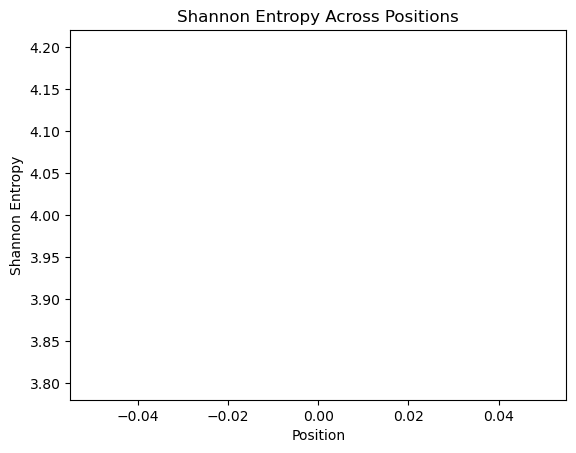

In [35]:
plt.plot(b)
plt.xlabel("Position")
plt.ylabel("Shannon Entropy")
plt.title("Shannon Entropy Across Positions")
plt.show()

In [36]:
b

4